# Baseline Models - METR-LA Dataset
Run the cells in this notebook to train and evaluate the baseline MLP and KDE models.
First, import the necessary libraries.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stblis_utils as stb
from stblis_classes import MLPNet
from scipy.stats import gaussian_kde
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

### Load the train, test, and val data
Shape is (num_samples, num_sensors, num_timesteps)

In [2]:
# Define the path to the compressed training data file
train_file_path = 'data/METR-LA/train.npz'

# Load the data for training
with np.load(train_file_path) as data:
    # Convert to float32 and permute dimensions (0, 2, 1, 3)
    x_train = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)
    y_train = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_train as well

x_train = x_train[..., 0]
y_train = y_train[..., 0]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Define the path to the compressed test data file
test_file_path = 'data/METR-LA/test.npz'

# Load the data for testing
with np.load(test_file_path) as data:
    x_test = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)  # Permuting dimensions for x_test
    y_test = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_test as well

x_test= x_test[..., 0]
y_test = y_test[..., 0]
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Define the path to the compressed validation data file
val_file_path = 'data/METR-LA/val.npz'

# Load the data for validation
with np.load(val_file_path) as data:
    x_val = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)  # Permuting dimensions for x_val
    y_val = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_val as well

x_val = x_val[..., 0]
y_val = y_val[..., 0]
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: torch.Size([23974, 207, 12])
y_train shape: torch.Size([23974, 207, 12])
x_test shape: torch.Size([6850, 207, 12])
y_test shape: torch.Size([6850, 207, 12])
x_val shape: torch.Size([3425, 207, 12])
y_val shape: torch.Size([3425, 207, 12])


### Load the adjacency matrix and create the time adjacency matrix. Create dictionaries for the mean and standard deviation values of each sensor, which can be used later to plot the original data.
Spatial adjacency matrix has shape (num_sensors, num_sensors).

Temporal adjacency matrix has shape (num_timesteps, num_timesteps).

In [3]:
# File paths
adj_file = 'adj_mx.pkl'
data_file = "data/METR-LA/metr-la.h5"

# Load adjacency matrix data from pickle file
with open(adj_file, 'rb') as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding='latin1')

# Convert adjacency matrix to a tensor and set its dtype to float32
adj_mx = torch.from_numpy(adj_mx).to(torch.float32)
print(f"Spatial adjacency Matrix Shape: {adj_mx.shape}")

# Generate time adjacency matrix
tadj_mx = stb.get_time_adj(x_train.shape[2])
print(f"Temporal Adjacency Matrix Shape: {tadj_mx.shape}")

# Load dataset
df = pd.read_hdf(data_file)

# Compute mean and standard deviation for each sensor, store in dict
mean_values = df.mean().to_dict()
std_values = df.std().to_dict()

# Map mean and std values to the corresponding sensor indices
mean_ind_dict = {
    sensor_id_to_ind[sensor_id]: mean_values[sensor_id]
    for sensor_id in mean_values if sensor_id in sensor_id_to_ind
}

std_ind_dict = {
    sensor_id_to_ind[sensor_id]: std_values[sensor_id]
    for sensor_id in std_values if sensor_id in sensor_id_to_ind
}

Spatial adjacency Matrix Shape: torch.Size([207, 207])
Temporal Adjacency Matrix Shape: torch.Size([12, 12])


### Set model hyperparameters

In [4]:
# MLP Parameters
_, num_nodes, num_timesteps = x_train.shape
mlp_input_dim = num_nodes * num_timesteps
embedding_dim = int(mlp_input_dim / 4)
output_dim = 12

# Training parameters
batch_size = 64
num_epochs = 50
patience, trigger_times = 10, 0  # Patience of 10 epochs
learning_rate = 0.001
num_trainings = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device detected: {device}")

Device detected: cuda


### Load original data into dataloaders

In [5]:
# Create new DataLoaders for precomputed data
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

### Train the model multiple times

In [6]:
for train_iter in range(num_trainings):
    print(f"\n\nTRAINING MODEL {train_iter+1}\n\n")
        
    # Define model save name
    model_save_name = f'best_MLP_model_{train_iter+1}.pth'
    
    # Define a new model for each training iteration
    mlp_model = MLPNet(mlp_input_dim, embedding_dim, output_dim, num_nodes, device).to(device)
                                                                                      
    # Wrap model with DataParallel to utilize all GPU resources
    if torch.cuda.device_count() > 1:
        mlp_model = nn.DataParallel(mlp_model)
    
    # Defien loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        mlp_model.train()
        train_loss = 0.0
        
        for x_batch, y_batch in tqdm(train_loader, desc=f"Train Epoch {epoch + 1}"):
            x_b, y_b = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Pad batch with zeros on last batch
            A, B, C = x_b.shape
            if A != batch_size:
                x_b = stb.pad_tensor(x_b, batch_size)
                y_b = stb.pad_tensor(y_b, batch_size)
                A, B, C = x_b.shape
                        
            x_b = x_b.reshape(A, B*C)
            
            output = mlp_model(x_b)
            loss = criterion(output, y_b)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_b.size(0)
        
        train_loss /= len(train_loader.dataset)
    
        # Validation loop
        mlp_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                x_b, y_b = x_val_batch.to(device), y_val_batch.to(device)

                # Pad batch with zeros on last batch
                A, B, C = x_b.shape
                if A != batch_size:
                    x_b = stb.pad_tensor(x_b, batch_size)
                    y_b = stb.pad_tensor(y_b, batch_size)
                    A, B, C = x_b.shape
                    
                x_b = x_b.reshape(A, B*C)
                
                output = mlp_model(x_b)
                loss = criterion(output, y_b)
                val_loss += loss.item() * x_b.size(0)
        
        val_loss /= len(val_loader.dataset)
    
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(mlp_model.state_dict(), model_save_name)
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Model {train_iter+1}: Early stopping!')
                break
    
        print(f'Model {train_iter+1}: Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')



TRAINING MODEL 1




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 288.39it/s]


Model 1: Epoch 1/50, Train Loss: 0.4255, Validation Loss: 0.3355


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 294.65it/s]


Model 1: Epoch 2/50, Train Loss: 0.3570, Validation Loss: 0.3281


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 288.21it/s]


Model 1: Epoch 3/50, Train Loss: 0.3413, Validation Loss: 0.3315


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 292.62it/s]


Model 1: Epoch 4/50, Train Loss: 0.3291, Validation Loss: 0.3155


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.85it/s]


Model 1: Epoch 5/50, Train Loss: 0.3264, Validation Loss: 0.3076


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 277.05it/s]


Model 1: Epoch 6/50, Train Loss: 0.3227, Validation Loss: 0.2862


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 290.83it/s]


Model 1: Epoch 7/50, Train Loss: 0.3170, Validation Loss: 0.2859


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.17it/s]


Model 1: Epoch 8/50, Train Loss: 0.3153, Validation Loss: 0.3120


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 287.12it/s]


Model 1: Epoch 9/50, Train Loss: 0.3125, Validation Loss: 0.2831


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 290.20it/s]


Model 1: Epoch 10/50, Train Loss: 0.3098, Validation Loss: 0.2865


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 291.37it/s]


Model 1: Epoch 11/50, Train Loss: 0.3087, Validation Loss: 0.2759


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 288.10it/s]


Model 1: Epoch 12/50, Train Loss: 0.3065, Validation Loss: 0.2767


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 289.21it/s]


Model 1: Epoch 13/50, Train Loss: 0.3078, Validation Loss: 0.3028


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 286.25it/s]


Model 1: Epoch 14/50, Train Loss: 0.3017, Validation Loss: 0.2771


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 289.34it/s]


Model 1: Epoch 15/50, Train Loss: 0.3027, Validation Loss: 0.2763


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 292.57it/s]


Model 1: Epoch 16/50, Train Loss: 0.3004, Validation Loss: 0.2774


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 290.60it/s]


Model 1: Epoch 17/50, Train Loss: 0.2980, Validation Loss: 0.2958


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 295.71it/s]


Model 1: Epoch 18/50, Train Loss: 0.2975, Validation Loss: 0.2755


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.88it/s]


Model 1: Epoch 19/50, Train Loss: 0.2947, Validation Loss: 0.2704


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 296.15it/s]


Model 1: Epoch 20/50, Train Loss: 0.2943, Validation Loss: 0.2704


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 290.47it/s]


Model 1: Epoch 21/50, Train Loss: 0.2939, Validation Loss: 0.2888


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 292.12it/s]


Model 1: Epoch 22/50, Train Loss: 0.2930, Validation Loss: 0.2809


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 291.42it/s]


Model 1: Epoch 23/50, Train Loss: 0.2927, Validation Loss: 0.2833


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.99it/s]


Model 1: Epoch 24/50, Train Loss: 0.2942, Validation Loss: 0.2730


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.50it/s]


Model 1: Epoch 25/50, Train Loss: 0.2918, Validation Loss: 0.2716


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 289.14it/s]


Model 1: Epoch 26/50, Train Loss: 0.2914, Validation Loss: 0.2704


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 293.58it/s]


Model 1: Epoch 27/50, Train Loss: 0.2910, Validation Loss: 0.2831


Validation Epoch 28: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.59it/s]


Model 1: Epoch 28/50, Train Loss: 0.2906, Validation Loss: 0.2813


Validation Epoch 29: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 287.13it/s]


Model 1: Epoch 29/50, Train Loss: 0.2894, Validation Loss: 0.2901


Validation Epoch 30: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.29it/s]


Model 1: Epoch 30/50, Train Loss: 0.2895, Validation Loss: 0.2807


Validation Epoch 31: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.43it/s]


Model 1: Epoch 31/50, Train Loss: 0.2902, Validation Loss: 0.2733


Validation Epoch 32: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 285.58it/s]


Model 1: Epoch 32/50, Train Loss: 0.2906, Validation Loss: 0.2808


Validation Epoch 33: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 273.16it/s]


Model 1: Epoch 33/50, Train Loss: 0.2868, Validation Loss: 0.2842


Validation Epoch 34: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 270.81it/s]


Model 1: Epoch 34/50, Train Loss: 0.2863, Validation Loss: 0.2733


Validation Epoch 35: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 273.77it/s]


Model 1: Epoch 35/50, Train Loss: 0.2873, Validation Loss: 0.2918


Validation Epoch 36: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 267.42it/s]


Model 1: Epoch 36/50, Train Loss: 0.2863, Validation Loss: 0.2662


Validation Epoch 37: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.49it/s]


Model 1: Epoch 37/50, Train Loss: 0.2878, Validation Loss: 0.2677


Validation Epoch 38: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.12it/s]


Model 1: Epoch 38/50, Train Loss: 0.2856, Validation Loss: 0.2695


Validation Epoch 39: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.78it/s]


Model 1: Epoch 39/50, Train Loss: 0.2867, Validation Loss: 0.2835


Validation Epoch 40: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 282.32it/s]


Model 1: Epoch 40/50, Train Loss: 0.2836, Validation Loss: 0.2729


Validation Epoch 41: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.05it/s]


Model 1: Epoch 41/50, Train Loss: 0.2848, Validation Loss: 0.2875


Validation Epoch 42: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 282.35it/s]


Model 1: Epoch 42/50, Train Loss: 0.2861, Validation Loss: 0.2984


Validation Epoch 43: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.87it/s]


Model 1: Epoch 43/50, Train Loss: 0.2844, Validation Loss: 0.2694


Validation Epoch 44: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 286.49it/s]


Model 1: Epoch 44/50, Train Loss: 0.2846, Validation Loss: 0.2757


Validation Epoch 45: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.55it/s]


Model 1: Epoch 45/50, Train Loss: 0.2831, Validation Loss: 0.2845


Validation Epoch 46: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.94it/s]


Model 1: Early stopping!


TRAINING MODEL 2




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 282.40it/s]


Model 2: Epoch 1/50, Train Loss: 0.4262, Validation Loss: 0.3295


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.42it/s]


Model 2: Epoch 2/50, Train Loss: 0.3583, Validation Loss: 0.3061


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 287.79it/s]


Model 2: Epoch 3/50, Train Loss: 0.3419, Validation Loss: 0.3098


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 285.96it/s]


Model 2: Epoch 4/50, Train Loss: 0.3340, Validation Loss: 0.3093


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 272.25it/s]


Model 2: Epoch 5/50, Train Loss: 0.3257, Validation Loss: 0.3258


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.32it/s]


Model 2: Epoch 6/50, Train Loss: 0.3207, Validation Loss: 0.2859


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.61it/s]


Model 2: Epoch 7/50, Train Loss: 0.3176, Validation Loss: 0.3075


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 286.91it/s]


Model 2: Epoch 8/50, Train Loss: 0.3145, Validation Loss: 0.2969


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.65it/s]


Model 2: Epoch 9/50, Train Loss: 0.3147, Validation Loss: 0.2835


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.79it/s]


Model 2: Epoch 10/50, Train Loss: 0.3101, Validation Loss: 0.3129


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 287.51it/s]


Model 2: Epoch 11/50, Train Loss: 0.3103, Validation Loss: 0.2790


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 268.44it/s]


Model 2: Epoch 12/50, Train Loss: 0.3085, Validation Loss: 0.2884


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.75it/s]


Model 2: Epoch 13/50, Train Loss: 0.3063, Validation Loss: 0.2752


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.43it/s]


Model 2: Epoch 14/50, Train Loss: 0.3045, Validation Loss: 0.3039


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.68it/s]


Model 2: Epoch 15/50, Train Loss: 0.3037, Validation Loss: 0.2912


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.34it/s]


Model 2: Epoch 16/50, Train Loss: 0.3027, Validation Loss: 0.3043


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 270.72it/s]


Model 2: Epoch 17/50, Train Loss: 0.3017, Validation Loss: 0.2969


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 273.62it/s]


Model 2: Epoch 18/50, Train Loss: 0.3007, Validation Loss: 0.2905


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 266.22it/s]


Model 2: Epoch 19/50, Train Loss: 0.2974, Validation Loss: 0.2726


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 273.56it/s]


Model 2: Epoch 20/50, Train Loss: 0.2979, Validation Loss: 0.2920


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 269.95it/s]


Model 2: Epoch 21/50, Train Loss: 0.2961, Validation Loss: 0.3020


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 263.15it/s]


Model 2: Epoch 22/50, Train Loss: 0.2961, Validation Loss: 0.2803


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 264.30it/s]


Model 2: Epoch 23/50, Train Loss: 0.2958, Validation Loss: 0.2777


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.30it/s]


Model 2: Epoch 24/50, Train Loss: 0.2943, Validation Loss: 0.2737


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 278.80it/s]


Model 2: Epoch 25/50, Train Loss: 0.2943, Validation Loss: 0.2727


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.47it/s]


Model 2: Epoch 26/50, Train Loss: 0.2929, Validation Loss: 0.2718


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.16it/s]


Model 2: Epoch 27/50, Train Loss: 0.2920, Validation Loss: 0.2782


Validation Epoch 28: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.81it/s]


Model 2: Epoch 28/50, Train Loss: 0.2909, Validation Loss: 0.2733


Validation Epoch 29: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 278.57it/s]


Model 2: Epoch 29/50, Train Loss: 0.2921, Validation Loss: 0.2777


Validation Epoch 30: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 277.16it/s]


Model 2: Epoch 30/50, Train Loss: 0.2905, Validation Loss: 0.2816


Validation Epoch 31: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.02it/s]


Model 2: Epoch 31/50, Train Loss: 0.2919, Validation Loss: 0.2750


Validation Epoch 32: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 278.27it/s]


Model 2: Epoch 32/50, Train Loss: 0.2914, Validation Loss: 0.2697


Validation Epoch 33: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.26it/s]


Model 2: Epoch 33/50, Train Loss: 0.2905, Validation Loss: 0.2798


Validation Epoch 34: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.80it/s]


Model 2: Epoch 34/50, Train Loss: 0.2886, Validation Loss: 0.2861


Validation Epoch 35: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.74it/s]


Model 2: Epoch 35/50, Train Loss: 0.2877, Validation Loss: 0.2698


Validation Epoch 36: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.21it/s]


Model 2: Epoch 36/50, Train Loss: 0.2888, Validation Loss: 0.2703


Validation Epoch 37: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.75it/s]


Model 2: Epoch 37/50, Train Loss: 0.2879, Validation Loss: 0.2699


Validation Epoch 38: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.26it/s]


Model 2: Epoch 38/50, Train Loss: 0.2877, Validation Loss: 0.2725


Validation Epoch 39: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 285.14it/s]


Model 2: Epoch 39/50, Train Loss: 0.2863, Validation Loss: 0.2751


Validation Epoch 40: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.51it/s]


Model 2: Epoch 40/50, Train Loss: 0.2872, Validation Loss: 0.2759


Validation Epoch 41: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.40it/s]


Model 2: Epoch 41/50, Train Loss: 0.2856, Validation Loss: 0.3000


Validation Epoch 42: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.48it/s]


Model 2: Early stopping!


TRAINING MODEL 3




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 278.93it/s]


Model 3: Epoch 1/50, Train Loss: 0.4207, Validation Loss: 0.3446


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 282.47it/s]


Model 3: Epoch 2/50, Train Loss: 0.3573, Validation Loss: 0.3198


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.95it/s]


Model 3: Epoch 3/50, Train Loss: 0.3424, Validation Loss: 0.3045


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 275.07it/s]


Model 3: Epoch 4/50, Train Loss: 0.3323, Validation Loss: 0.3043


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.38it/s]


Model 3: Epoch 5/50, Train Loss: 0.3268, Validation Loss: 0.2960


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 285.18it/s]


Model 3: Epoch 6/50, Train Loss: 0.3211, Validation Loss: 0.2923


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 282.46it/s]


Model 3: Epoch 7/50, Train Loss: 0.3176, Validation Loss: 0.2909


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.95it/s]


Model 3: Epoch 8/50, Train Loss: 0.3151, Validation Loss: 0.2895


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.99it/s]


Model 3: Epoch 9/50, Train Loss: 0.3138, Validation Loss: 0.2809


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.63it/s]


Model 3: Epoch 10/50, Train Loss: 0.3097, Validation Loss: 0.2895


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.70it/s]


Model 3: Epoch 11/50, Train Loss: 0.3088, Validation Loss: 0.3050


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.58it/s]


Model 3: Epoch 12/50, Train Loss: 0.3067, Validation Loss: 0.2864


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.44it/s]


Model 3: Epoch 13/50, Train Loss: 0.3053, Validation Loss: 0.2837


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 278.42it/s]


Model 3: Epoch 14/50, Train Loss: 0.3052, Validation Loss: 0.2981


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 287.64it/s]


Model 3: Epoch 15/50, Train Loss: 0.3043, Validation Loss: 0.2803


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.87it/s]


Model 3: Epoch 16/50, Train Loss: 0.3019, Validation Loss: 0.2710


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.81it/s]


Model 3: Epoch 17/50, Train Loss: 0.3025, Validation Loss: 0.3047


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 266.90it/s]


Model 3: Epoch 18/50, Train Loss: 0.3001, Validation Loss: 0.2830


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 280.14it/s]


Model 3: Epoch 19/50, Train Loss: 0.3004, Validation Loss: 0.2947


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 264.77it/s]


Model 3: Epoch 20/50, Train Loss: 0.2988, Validation Loss: 0.2787


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.71it/s]


Model 3: Epoch 21/50, Train Loss: 0.2984, Validation Loss: 0.2717


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 275.79it/s]


Model 3: Epoch 22/50, Train Loss: 0.2965, Validation Loss: 0.2729


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 277.32it/s]


Model 3: Epoch 23/50, Train Loss: 0.2948, Validation Loss: 0.2839


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 281.91it/s]


Model 3: Epoch 24/50, Train Loss: 0.2963, Validation Loss: 0.2884


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 283.82it/s]


Model 3: Epoch 25/50, Train Loss: 0.2950, Validation Loss: 0.2730


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 284.23it/s]

Model 3: Early stopping!


### Evaluate the trained models
We will generate the predicted outputs and store them in a dictionary, allowing us to plot them later

In [7]:
model_preds_dict = {}
model_actuals_dict = {}
for test_iter in range(num_trainings):

    # Load model for testing
    model_save_name = f'best_MLP_model_{test_iter+1}.pth'
    
    # Load the trained model's state dictionary
    state_dict = torch.load(model_save_name)
    
    # Remove 'module.' prefix if present
    state_dict = stb.remove_module_prefix(state_dict)

    # Load model parameters
    mlp_model = MLPNet(mlp_input_dim, embedding_dim, output_dim, num_nodes, device).to(device)
    mlp_model.load_state_dict(state_dict)
    
    # Define loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
    
    # Testing loop
    mlp_model.eval()
    test_loss = 0.0

    all_test_preds = []
    all_test_actuals = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc=f"Evaluating on Test Data"):
            x_b, y_b = x_batch.to(device), y_batch.to(device)

            # Pad batch_size on last batch so that it is the same as the other batch sizes
            A, B, C = x_b.shape
            if A != batch_size:
                x_b = stb.pad_tensor(x_b, batch_size)
                y_b = stb.pad_tensor(y_b, batch_size)
                A, B, C = x_b.shape
        
            x_b = x_b.reshape(A, B*C)
            
            output = mlp_model(x_b)
            loss = criterion(output, y_b)
            test_loss += loss.item() * x_b.size(0)
            all_test_preds.append(output.cpu())
            all_test_actuals.append(y_b.cpu())
    
    all_test_preds = torch.cat(all_test_preds, dim=0)
    all_test_actuals = torch.cat(all_test_actuals, dim=0)
    
    test_loss /= len(test_loader.dataset)
    print(f'Model {test_iter+1}: Test Loss: {test_loss:.4f}')

    # Save predictions and actuals in a dictionary for easy access later
    model_preds_dict[test_iter+1] = all_test_preds
    model_actuals_dict[test_iter+1] = all_test_actuals

Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 108/108 [00:00<00:00, 748.37it/s]


Model 1: Test Loss: 0.3267


Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 108/108 [00:00<00:00, 693.30it/s]


Model 2: Test Loss: 0.3369


Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 108/108 [00:00<00:00, 931.06it/s]

Model 3: Test Loss: 0.3323


### Generate sample plots of the predicted outputs

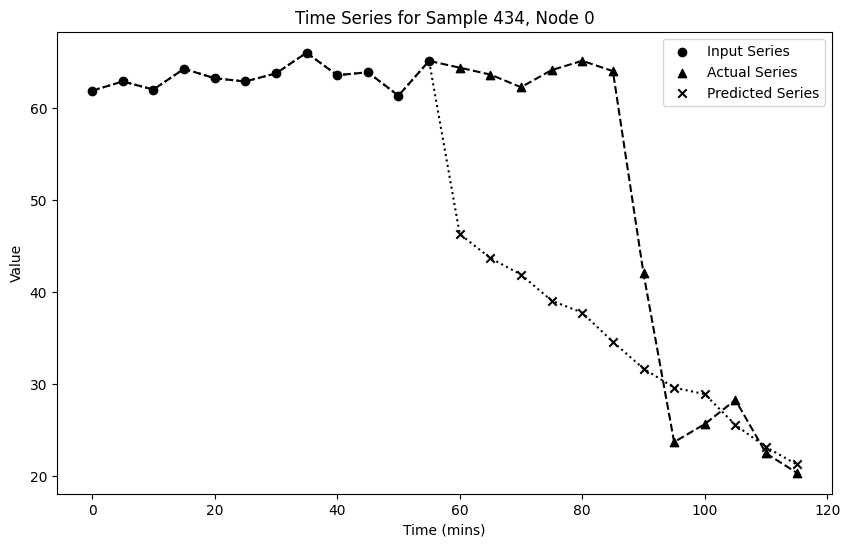

In [8]:
model_num = 3 # Specify the model you want to plot. This is 1-indexed
sample_index = 434  # Specify the sample index you want to plot
node_index = 0 # Specify the node index you want to plot
model_test_preds = model_preds_dict[model_num]
model_test_actuals = model_actuals_dict[model_num]

# Call helper function to plot the predicted vs actual output
stb.plot_time_series(sample_index, node_index, x_test, model_test_actuals, model_test_preds, num_timesteps, num_nodes, output_dim, mean_ind_dict, std_ind_dict, zscore=False)

### Calculate metrics for model evaluation

In [11]:
# Initialize empty dictionaries to hold the sum of metrics and squared sum for std calculation
# Index 2 is 15 mins, index 5 is 30 mins, index 11 is 60 mins (each index is a 5 min interval)
avg_metrics = {}
std_metrics = {}
indices = [2, 5, 11]

# Initialize the dictionaries to accumulate metrics and squared metrics for each index
for idx in indices:
    avg_metrics[idx] = {'MAE': 0, 'RMSE': 0, 'MAPE': 0}
    std_metrics[idx] = {'MAE': 0, 'RMSE': 0, 'MAPE': 0}

# Loop over each training/trial
for model_num in range(num_trainings):
    model_test_preds = model_preds_dict[model_num + 1]
    model_test_actuals = model_actuals_dict[model_num + 1]
    
    # Get metrics for this trial
    metrics = stb.calculate_metrics_per_index(model_test_preds, model_test_actuals, indices)
    
    # Accumulate the metrics and squared metrics for averaging and std calculation
    for idx in metrics:
        for metric in metrics[idx]:
            avg_metrics[idx][metric] += metrics[idx][metric]
            std_metrics[idx][metric] += metrics[idx][metric] ** 2

# Calculate the average and std across all trials
for idx in avg_metrics:
    for metric in avg_metrics[idx]:
        avg_metrics[idx][metric] /= num_trainings
        std_metrics[idx][metric] = np.sqrt(std_metrics[idx][metric] / num_trainings - avg_metrics[idx][metric] ** 2)

# Print the averaged and std metrics for each index
print(f"Average metrics over {num_trainings} training samples:")
for idx in avg_metrics:
    print(f"Time Prediction {(idx + 1) * 5} mins: "
          f"Avg MAE: {avg_metrics[idx]['MAE']:.4f}, "
          f"Avg RMSE: {avg_metrics[idx]['RMSE']:.4f}, "
          f"Avg MAPE: {avg_metrics[idx]['MAPE']:.4f}, "
          f"Std MAE: {std_metrics[idx]['MAE']:.4f}, "
          f"Std RMSE: {std_metrics[idx]['RMSE']:.4f}, "
          f"Std MAPE: {std_metrics[idx]['MAPE']:.4f}")


Average metrics over 3 training samples:
Time Prediction 15 mins: Avg MAE: 0.2896, Avg RMSE: 0.6180, Avg MAPE: 1.6571, Std MAE: 0.0045, Std RMSE: 0.0024, Std MAPE: 0.0162
Time Prediction 30 mins: Avg MAE: 0.3259, Avg RMSE: 0.7061, Avg MAPE: 1.8606, Std MAE: 0.0044, Std RMSE: 0.0011, Std MAPE: 0.0099
Time Prediction 60 mins: Avg MAE: 0.3863, Avg RMSE: 0.8142, Avg MAPE: 1.9723, Std MAE: 0.0038, Std RMSE: 0.0005, Std MAPE: 0.0014


### Train a KDE baseline
We will train a KDE model multiple times and randomly sample from the probability distribution for the ouptut. We will evaluate the metrics on this model, which should give us a baseline for a random model's behavior.

In [12]:
# Define the number of trials and relevant indices
# Index 2 is 15 mins, index 5 is 30 mins, index 11 is 60 mins (each index is a 5 min interval)
num_trials = 3
indices = [2, 5, 11]

# Initialize lists to store all metrics across trials
all_mae, all_rmse, all_mape = [], [], []
squared_mae, squared_rmse, squared_mape = [], [], []

# Run the experiment multiple times and store the results
for trial in range(num_trials):
    # Train KDE on flattened x_train
    kde = gaussian_kde(x_train.flatten())

    # Generate new samples from the KDE
    num_samples = y_test.numel()  # Total number of elements in y_test
    generated_samples = kde.resample(num_samples).flatten()

    # Convert generated samples into a torch tensor with the shape of y_test
    random_preds = torch.tensor(generated_samples, dtype=torch.float32).reshape(y_test.shape)

    # Calculate metrics for the current trial
    metrics = stb.calculate_metrics_per_index(random_preds, y_test, indices)

    # Store the metrics for this trial
    for idx in metrics:
        all_mae.append(metrics[idx]['MAE'])
        all_rmse.append(metrics[idx]['RMSE'])
        all_mape.append(metrics[idx]['MAPE'])
        
        # Store squared values for std calculation
        squared_mae.append(metrics[idx]['MAE'] ** 2)
        squared_rmse.append(metrics[idx]['RMSE'] ** 2)
        squared_mape.append(metrics[idx]['MAPE'] ** 2)

# Calculate the averages and standard deviations of each metric
avg_mae = np.mean(all_mae)
avg_rmse = np.mean(all_rmse)
avg_mape = np.mean(all_mape)

std_mae = np.sqrt(np.mean(squared_mae) - avg_mae ** 2)
std_rmse = np.sqrt(np.mean(squared_rmse) - avg_rmse ** 2)
std_mape = np.sqrt(np.mean(squared_mape) - avg_mape ** 2)

# Print the average and std results
print(f"Average over {num_trials} trials:")
for idx in indices:
    print(f"Time Prediction {(idx + 1) * 5} mins: "
          f"Avg MAE: {avg_mae:.4f}, "
          f"Avg RMSE: {avg_rmse:.4f}, "
          f"Avg MAPE: {avg_mape:.4f}, "
          f"Std MAE: {std_mae:.4f}, "
          f"Std RMSE: {std_rmse:.4f}, "
          f"Std MAPE: {std_mape:.4f}")

Average over 3 trials:
Time Prediction 15 mins: Avg MAE: 0.9753, Avg RMSE: 1.4993, Avg MAPE: 4.1284, Std MAE: 0.0007, Std RMSE: 0.0009, Std MAPE: 0.2011
Time Prediction 30 mins: Avg MAE: 0.9753, Avg RMSE: 1.4993, Avg MAPE: 4.1284, Std MAE: 0.0007, Std RMSE: 0.0009, Std MAPE: 0.2011
Time Prediction 60 mins: Avg MAE: 0.9753, Avg RMSE: 1.4993, Avg MAPE: 4.1284, Std MAE: 0.0007, Std RMSE: 0.0009, Std MAPE: 0.2011
